In [ ]:
#import các thư viện cần thiết
import pandas as pd
import networkx as nx
from networkx.algorithms import bipartite
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.cm as cm
import matplotlib
from community import community_louvain
import seaborn as sns
from termcolor import colored
from networkx.algorithms.community import label_propagation_communities
from sklearn import preprocessing
from sklearn.cluster import KMeans
np.random.seed(48)

In [ ]:
#đọc dữ liệu từ file csv
dt=pd.read_csv("data.csv")
dt = dt.dropna()
dt = dt.drop_duplicates()
dt

,Airline,Destination
0,Southwest Airlines Co,New York
1,Southwest Airlines Co,Tennessee
141,Southwest Airlines Co,Georgia
146,Southwest Airlines Co,Texas
148,Southwest Airlines Co,Illinois
...,...,...
18315,Sun Country Airlines dba MN Airlines,Texas
18417,Sun Country Airlines dba MN Airlines,New York
18615,Sun Country Airlines dba MN Airlines,Nevada
18775,Sun Country Airlines dba MN Airlines,California


In [ ]:
B = nx.Graph()
Airline = dt['Airline']
DestinationCountry = dt['Destination']
print('So Airline', Airline.nunique())
print('So DestinationCountry', DestinationCountry.nunique())
print('So canh', len(dt))

So Airline 7
So DestinationCountry 40
So canh 105


In [ ]:
for index, row in dt.iterrows():
    B.add_edge(row['Airline'], row['Destination'], weight=1)
B.add_nodes_from(DestinationCountry,bipartite=0)
B.add_nodes_from(Airline,bipartite=1)

<Figure size 1200x1200 with 0 Axes>

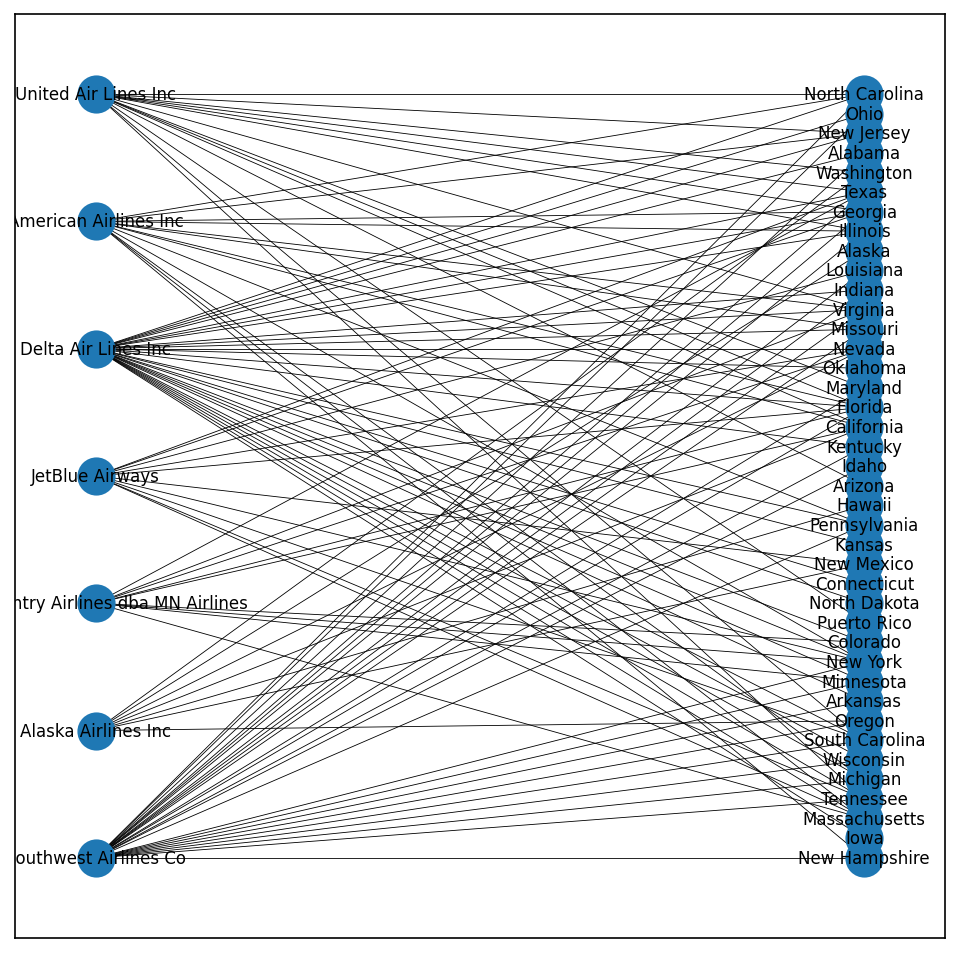

In [ ]:
plt.figure(figsize=(12,12))
pos = nx.spring_layout(B)
fig, ax = plt.subplots(1,1,figsize=(8,8), dpi=150)
nx.draw_networkx(B, pos = nx.drawing.layout.bipartite_layout(B, Airline),font_size=8,width=0.4)

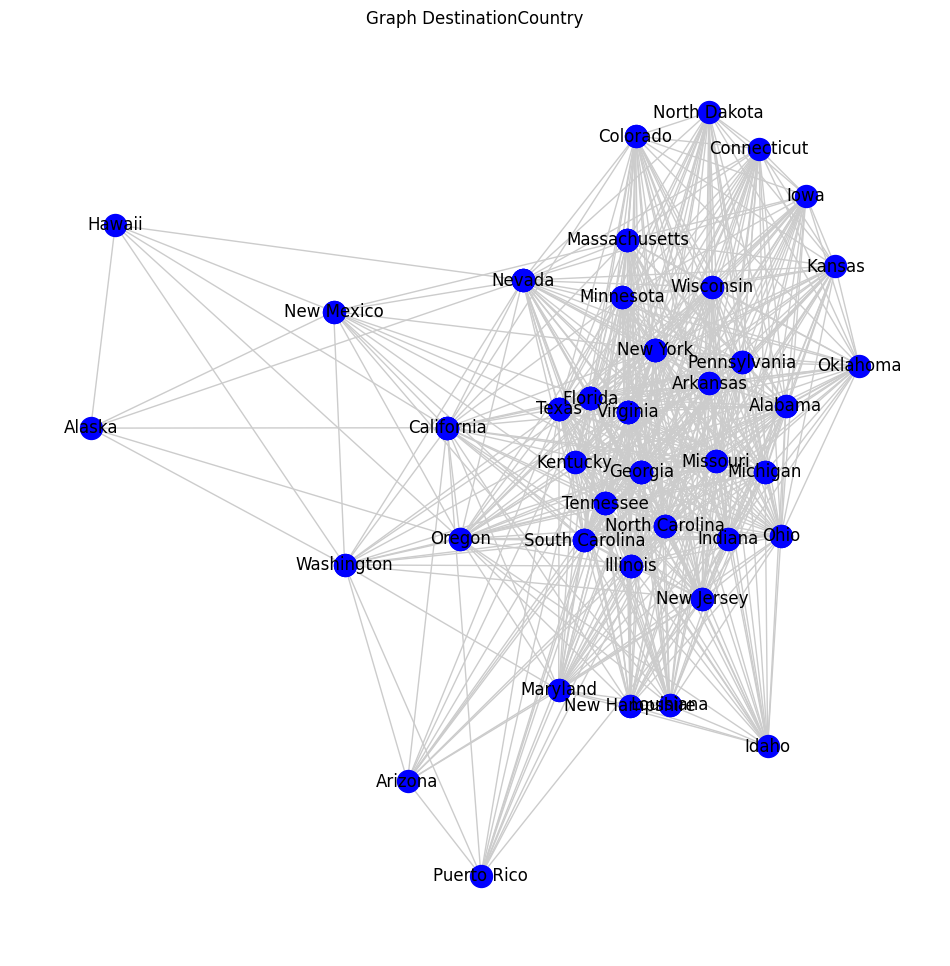

In [ ]:
A= set(DestinationCountry)
G = bipartite.weighted_projected_graph(B,A)
plt.figure(figsize=(12,12))

layout = nx.spring_layout(G)

nx.draw_networkx_nodes(G, layout,nodelist=DestinationCountry,node_size=250,node_color='blue')
nx.draw_networkx_edges(G, layout, edge_color='#cccccc')
node_labels = dict(zip(DestinationCountry, DestinationCountry))
nx.draw_networkx_labels(G, layout, labels=node_labels)
plt.axis('off')

plt.title("Graph DestinationCountry")

plt.show()

In [ ]:
edges= G.edges.data()

In [ ]:
data = pd.DataFrame(edges,columns=['u','v','weight'])
data
data.to_csv('Gelphi.csv')

In [ ]:
data

,u,v,weight
0,New Hampshire,California,{'weight': 1}
1,New Hampshire,Tennessee,{'weight': 1}
2,New Hampshire,Michigan,{'weight': 2}
3,New Hampshire,Wisconsin,{'weight': 1}
4,New Hampshire,Florida,{'weight': 2}
...,...,...,...
565,New Jersey,Massachusetts,{'weight': 2}
566,New Jersey,North Carolina,{'weight': 3}
567,Ohio,Massachusetts,{'weight': 1}
568,Ohio,North Carolina,{'weight': 2}


In [ ]:
G = nx.Graph()

edges = data[['u', 'v']]
G = nx.from_pandas_edgelist(edges, 'u', 'v')

print('Số đỉnh của đồ thị là', len(G.nodes()))
print('Số cạnh của đồ thị là', len(G.edges()))

Số đỉnh của đồ thị là 40
Số cạnh của đồ thị là 570


In [ ]:
print('Kiểm tra đồ thị liên thông: ')
nx.is_connected(G)

Kiểm tra đồ thị liên thông: 


True

# ***DEGREE***

In [ ]:
#degree of each node
def print_table(data, columns):
  df = pd.DataFrame(data, columns=columns)
  return df

degree_dict = { node: 0 for node in G.nodes() }

for node in G.nodes():
  degree_dict[node] = len(list(G.neighbors(node)))

degree_df = print_table(degree_dict.items(), ['Node', 'Degree'])

degree_df

,Node,Degree
0,New Hampshire,26
1,California,26
2,Tennessee,37
3,Michigan,33
4,Wisconsin,32
5,Florida,37
6,Maryland,28
7,South Carolina,37
8,Oregon,29
9,Arkansas,32


In [ ]:
sorted_degree_dict = sorted(degree_dict.items(), key=lambda item: item[1], reverse=True)
top_10_max_degree = list(sorted_degree_dict)[:10]

print('Top 10 node có bậc cao nhất : ')
print_table(top_10_max_degree, ['Node', 'Degree'])

Top 10 node có bậc cao nhất : 


,Node,Degree
0,Tennessee,37
1,Florida,37
2,South Carolina,37
3,Georgia,37
4,Texas,37
5,Virginia,36
6,Illinois,36
7,North Carolina,36
8,New York,34
9,Nevada,34


In [ ]:
sorted_degree_dict = sorted(degree_dict.items(), key=lambda item: item[1], reverse=False)
top_10_min_degree = list(sorted_degree_dict)[:10]

print('Top 10 node có bậc thấp nhất : ')
print_table(top_10_min_degree, ['Node', 'Degree'])

Top 10 node có bậc thấp nhất : 


,Node,Degree
0,Alaska,6
1,Hawaii,6
2,Puerto Rico,13
3,Arizona,13
4,New Mexico,14
5,Washington,18
6,Idaho,23
7,New Hampshire,26
8,California,26
9,Louisiana,26


Biểu đồ thể hiện phân bố bậc của các node trong graph


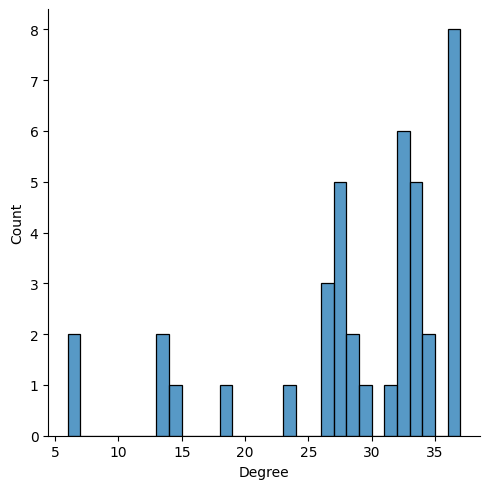

In [ ]:
print(colored("Biểu đồ thể hiện phân bố bậc của các node trong graph", 'green', attrs=['bold']))
sns.displot(x="Degree", data=degree_df, binwidth=1)

# ***CLONESS CENTRALITY***

In [ ]:
# reverse (bool, optional (default=False)) – If True and G is a digraph, reverse the edges of G, using successors instead of predecessors.
closeness_centrality = nx.closeness_centrality(G)

sorted_closeness_centrality = sorted(closeness_centrality.items(), key=lambda x:x[1], reverse=True)
closeness_centrality_df = print_table(closeness_centrality.items(), ['Node', 'Closeness centrality'])

closeness_centrality_df

,Node,Closeness centrality
0,New Hampshire,0.750000
1,California,0.750000
2,Tennessee,0.951220
3,Michigan,0.866667
4,Wisconsin,0.847826
5,Florida,0.951220
6,Maryland,0.780000
7,South Carolina,0.951220
8,Oregon,0.795918
9,Arkansas,0.847826


Biểu đồ thể hiện phân bố closeness centrality của các node trong graph


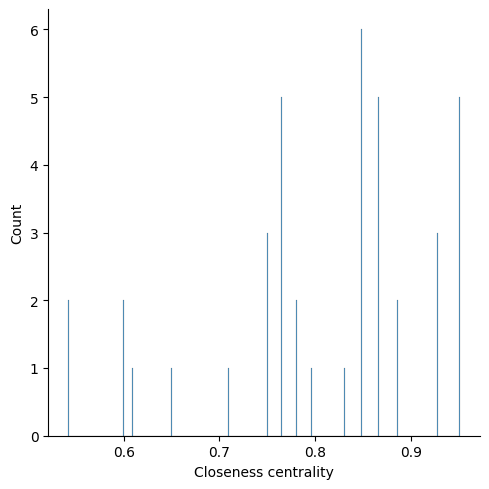

In [ ]:
print(colored("Biểu đồ thể hiện phân bố closeness centrality của các node trong graph", 'green', attrs=['bold']))
sns.displot(x="Closeness centrality", data=closeness_centrality_df, binwidth=0.001)

In [ ]:
top_ten_max_closeness_cen = sorted_closeness_centrality[:10]
print('Top 10 quốc gia có Closeness centrality cao nhất: ')
print_table(top_ten_max_closeness_cen, ['Counrty', 'Closeness centrality'])

Top 10 quốc gia có Closeness centrality cao nhất: 


,Counrty,Closeness centrality
0,Tennessee,0.951220
1,Florida,0.951220
2,South Carolina,0.951220
3,Georgia,0.951220
4,Texas,0.951220
5,Virginia,0.928571
6,Illinois,0.928571
7,North Carolina,0.928571
8,New York,0.886364
9,Nevada,0.886364


In [ ]:
top_ten_min_closeness_cen = sorted_closeness_centrality[-10:]
print('Top 10 quốc gia có Closeness centrality nhỏ nhất: ')
print_table(top_ten_min_closeness_cen, ['Counrty', 'Closeness centrality'])

Top 10 quốc gia có Closeness centrality nhỏ nhất: 


,Counrty,Closeness centrality
0,New Hampshire,0.750000
1,California,0.750000
2,Louisiana,0.750000
3,Idaho,0.709091
4,Washington,0.650000
5,New Mexico,0.609375
6,Puerto Rico,0.600000
7,Arizona,0.600000
8,Alaska,0.541667
9,Hawaii,0.541667


# ***BETWEENESS CENTRALITY***

In [ ]:
bet_cen = nx.betweenness_centrality(G, normalized=False) #returns a dictionary
sorted_bet_cen = sorted(bet_cen.items(), key=lambda x:x[1], reverse=True)

bet_cen_df = print_table(bet_cen.items(), ['Node', 'Betweenness centrality'])

bet_cen_df

,Node,Betweenness centrality
0,New Hampshire,0.680660
1,California,16.819208
2,Tennessee,11.676614
3,Michigan,2.586021
4,Wisconsin,1.876772
5,Florida,11.676614
6,Maryland,4.610855
7,South Carolina,11.676614
8,Oregon,20.230508
9,Arkansas,1.876772


Biểu đồ thể hiện phân bố betweenness centrality của các node trong graph


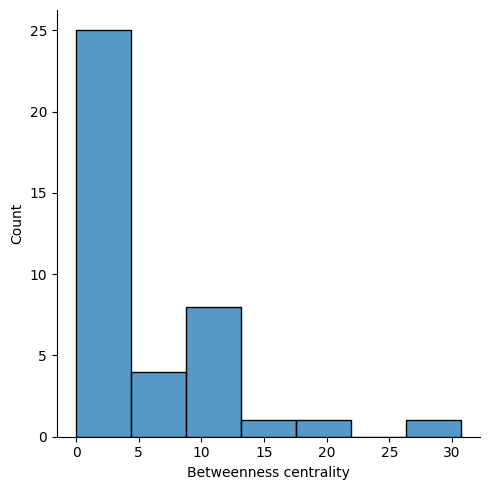

In [ ]:
print(colored("Biểu đồ thể hiện phân bố betweenness centrality của các node trong graph", color='	#FF4040', attrs=['bold']))
sns.displot(x="Betweenness centrality", data=bet_cen_df)

In [ ]:
top_ten_max_bet_cen = sorted_bet_cen[:10]
print('Top 10 quốc gia có Betweenness centrality lớn nhất: ')
print_table(top_ten_max_bet_cen, ['DestinationCountry', 'Betweenness centrality'])

Top 10 quốc gia có Betweenness centrality lớn nhất: 


,DestinationCountry,Betweenness centrality
0,Nevada,30.710005
1,Oregon,20.230508
2,California,16.819208
3,Tennessee,11.676614
4,Florida,11.676614
5,South Carolina,11.676614
6,Georgia,11.676614
7,Texas,11.676614
8,Virginia,9.016152
9,Illinois,9.016152


# ***EIGENVECTOR***

In [ ]:
eig_cen = nx.eigenvector_centrality(G, max_iter=100)

sorted_eig_cen = sorted(eig_cen.items(), key=lambda x:x[1], reverse=True)

eig_cen_df = print_table(eig_cen.items(), ['Node', 'Eigenvector Centrality'])

eig_cen_df

,Node,Eigenvector Centrality
0,New Hampshire,0.145453
1,California,0.124156
2,Tennessee,0.188706
3,Michigan,0.179878
4,Wisconsin,0.175986
5,Florida,0.188706
6,Maryland,0.146965
7,South Carolina,0.188706
8,Oregon,0.145939
9,Arkansas,0.175986


Biểu đồ thể hiện phân bố Eigenvector Centrality của các node trong graph


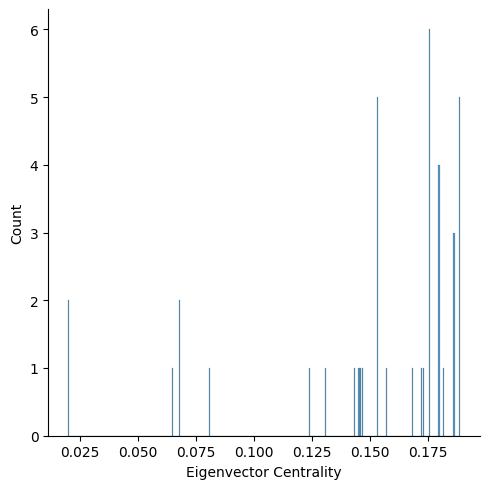

In [ ]:
print(colored("Biểu đồ thể hiện phân bố Eigenvector Centrality của các node trong graph", 'green', attrs=['bold']))
sns.displot(x="Eigenvector Centrality", data=eig_cen_df, binwidth=0.0005)

In [ ]:
top_ten_max_eig_cen_df = sorted_eig_cen[:10]
print('Top 10 quốc gia có Eigenvector Centrality lớn nhất: ')
print_table(top_ten_max_eig_cen_df, ['DestinationCountry', 'Eigenvector Centrality'])

Top 10 quốc gia có Eigenvector Centrality lớn nhất: 


,DestinationCountry,Eigenvector Centrality
0,Tennessee,0.188706
1,Florida,0.188706
2,South Carolina,0.188706
3,Georgia,0.188706
4,Texas,0.188706
5,Virginia,0.186676
6,Illinois,0.186676
7,North Carolina,0.186676
8,New York,0.181908
9,Michigan,0.179878


In [ ]:
top_ten_min_eig_cen_df = sorted_eig_cen[-5:]
print('Top 10 quốc gia có Eigenvector Centrality nhỏ nhất: ')
print_table(top_ten_min_eig_cen_df, ['DestinationCountry', 'Eigenvector Centrality'])

Top 10 quốc gia có Eigenvector Centrality nhỏ nhất: 


,DestinationCountry,Eigenvector Centrality
0,Puerto Rico,0.067870
1,Arizona,0.067870
2,New Mexico,0.064745
3,Alaska,0.019678
4,Hawaii,0.019678


# ***PAGERANK***

In [ ]:
pagerank = nx.pagerank(G, tol=1e-6, alpha=0.85)
sorted_pagerank = sorted(pagerank.items(), key=lambda x:x[1], reverse=True)

pagerank_df = print_table(pagerank.items(), ['Node', 'Pagerank'])

pagerank_df

,Node,Pagerank
0,New Hampshire,0.022751
1,California,0.024547
2,Tennessee,0.031522
3,Michigan,0.027934
4,Wisconsin,0.027131
5,Florida,0.031522
6,Maryland,0.024675
7,South Carolina,0.031522
8,Oregon,0.026436
9,Arkansas,0.027131


Biểu đồ thể hiện phân bố pagerank của các node trong graph


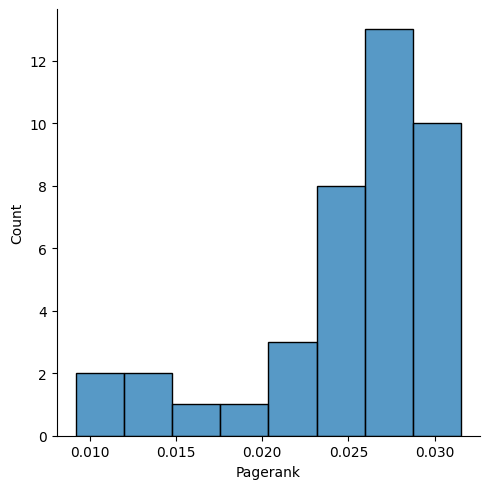

In [ ]:
print(colored("Biểu đồ thể hiện phân bố pagerank của các node trong graph", 'green', attrs=['bold']))
sns.displot(x="Pagerank", data=pagerank_df)

In [ ]:
top_ten_max_pagerank = sorted_pagerank[:10]
print('Top 10 quốc gia có Pagerank lớn nhất: ')
print_table(top_ten_max_pagerank, ['DestinationCountry', 'Pagerank'])

Top 10 quốc gia có Pagerank lớn nhất: 


,DestinationCountry,Pagerank
0,Tennessee,0.031522
1,Florida,0.031522
2,South Carolina,0.031522
3,Georgia,0.031522
4,Texas,0.031522
5,Virginia,0.030590
6,Illinois,0.030590
7,North Carolina,0.030590
8,Nevada,0.030075
9,New York,0.028866


In [ ]:
top_ten_min_pagerank = sorted_pagerank[-10:]
print('Top 10 quốc gia có Pagerank nhỏ nhất: ')
print_table(top_ten_min_pagerank, ['DestinationCountry', 'Pagerank'])

Top 10 quốc gia có Pagerank nhỏ nhất: 


,DestinationCountry,Pagerank
0,Kansas,0.023343
1,Louisiana,0.022901
2,New Hampshire,0.022751
3,Idaho,0.020477
4,Washington,0.018663
5,New Mexico,0.015388
6,Puerto Rico,0.013588
7,Arizona,0.013588
8,Alaska,0.009199
9,Hawaii,0.009199


# ***CLUSTERING***

***GIRVAN NEWMAN***

In [ ]:
def edge_to_remove(graph):
  G_dict = nx.edge_betweenness_centrality(graph)
  edge = ()

  # extract the edge with highest edge betweenness centrality score
  for key, value in sorted(G_dict.items(), key=lambda item: item[1], reverse = True):
      edge = key
      break

  return edge

In [ ]:
def girvan_newman(graph):
    # find number of connected components
    sg = nx.connected_components(graph)
    sg_count = nx.number_connected_components(graph)

    while(sg_count == 1):
        graph.remove_edge(edge_to_remove(graph)[0], edge_to_remove(graph)[1])
        sg = nx.connected_components(graph)
        sg_count = nx.number_connected_components(graph)
    return sg

In [ ]:
# find communities in the graph
c = girvan_newman(G.copy())

# find the nodes forming the communities
node_groups = []

for i in c:
  node_groups.append(list(i))

In [ ]:
import networkx as nx

def girvan_newman(G):
    # Create a deep copy of the graph to avoid modifying the original graph
    G_copy = G.copy()
    
    # Initialize the list of connected components
    components = [c for c in nx.connected_components(G_copy)]
    
    while len(components) == 1:
        # Calculate the betweenness centrality of all edges in the graph
        edge_betweenness = nx.edge_betweenness_centrality(G_copy)
        
        # Find the edge(s) with the highest betweenness centrality
        max_betweenness = max(edge_betweenness.values())
        max_betweenness_edges = [edge for edge, centrality in edge_betweenness.items() if centrality == max_betweenness]
        
        # Remove the edge(s) with the highest betweenness centrality
        for edge in max_betweenness_edges:
            G_copy.remove_edge(*edge)
        
        # Update the list of connected components
        components = [c for c in nx.connected_components(G_copy)]
    
    return components

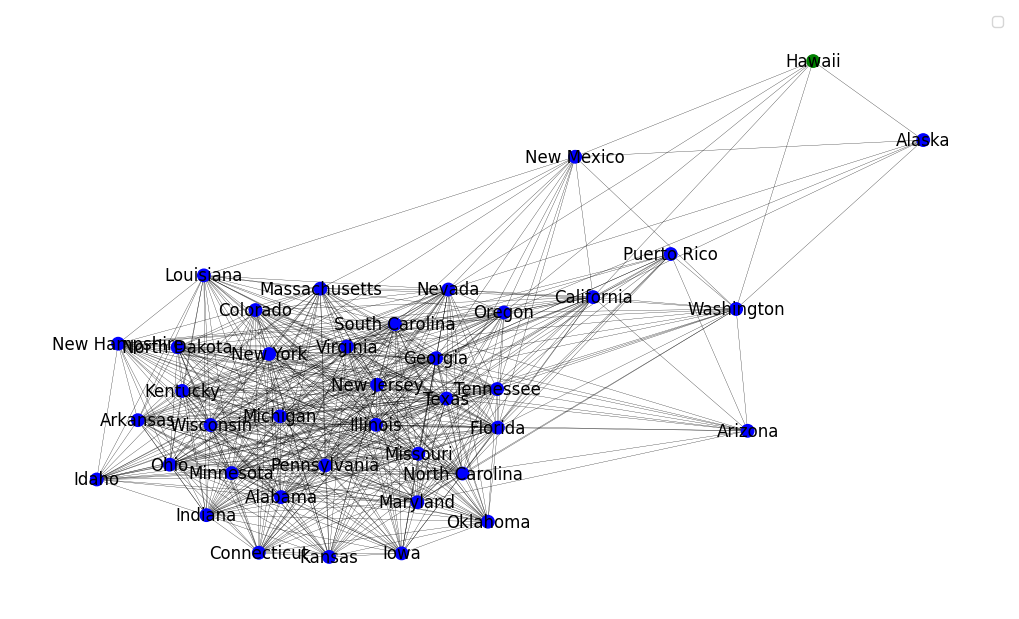

In [ ]:
# plot the communities
color_map = []
for node in G:
    if node in node_groups[0]:
        color_map.append('blue')
    else: 
        color_map.append('green')  

pd.set_option("display.precision",10)

nodes = G.nodes()
degree = G.degree()
colors = [degree[n] for n in nodes]

pos = nx.spring_layout(G)
fig = plt.figure(figsize = (10,6), dpi=100)



cmap = plt.cm.viridis_r
cmap = plt.cm.Greys

vmin = min(colors)
vmax = max(colors)


nx.draw(G, node_color=color_map, with_labels=True,node_size = 80,width = 0.2)
# nx.draw(G,pos,alpha = 0.8, nodelist = nodes, node_color = color_map, node_size = 20, with_labels= False,font_size = 6, width = 0.2, cmap = cmap, edge_color ='yellow')


plt.legend()
plt.show()

 ***LOUVAIN***

In [ ]:
plt.figure(figsize=(17,12))

#compute the best partition
partition = community_louvain.best_partition(G, resolution = 0.95)


<Figure size 1700x1200 with 0 Axes>

In [ ]:
clusters = set([cluster for _, cluster in partition.items()])
print('Số cụm trong graph là: ', len(clusters))

Số cụm trong graph là:  4


In [ ]:
louvain = pd.DataFrame.from_dict(partition, orient='index', columns=['Cluster'])
louvain.index.name = 'Node'
louvain

,Cluster
Node,
New Hampshire,3
California,2
Tennessee,0
Michigan,3
Wisconsin,3
Florida,1
Maryland,3
South Carolina,1
Oregon,3


In [ ]:
import pandas as pd
# Calculate the degree of each node in the graph
degrees = G.degree()

# Create the louvain DataFrame
louvain = pd.DataFrame.from_dict(partition, orient='index', columns=['Cluster'])
louvain.index.name = 'Node'

# Add a new column for the degree
louvain['Degree'] = [degrees[node] for node in louvain.index]

# Print the louvain DataFrame
print(louvain)

                Cluster  Degree
Node                           
New Hampshire         3      26
California            2      26
Tennessee             0      37
Michigan              3      33
Wisconsin             3      32
Florida               1      37
Maryland              3      28
South Carolina        1      37
Oregon                3      29
Arkansas              3      32
Minnesota             3      33
New York              3      34
Missouri              3      33
Virginia              3      36
Indiana               3      32
Louisiana             3      26
Illinois              3      36
Georgia               1      37
Texas                 0      37
Alabama               3      32
New Jersey            0      33
Pennsylvania          3      33
Idaho                 3      23
Ohio                  3      32
Kentucky              3      32
Massachusetts         0      31
North Carolina        3      36
Iowa                  0      27
Oklahoma              0      27
Nevada  

<ipython-input-40-5b4e902b9b8d>:7: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('rainbow', max(partition.values())+1)


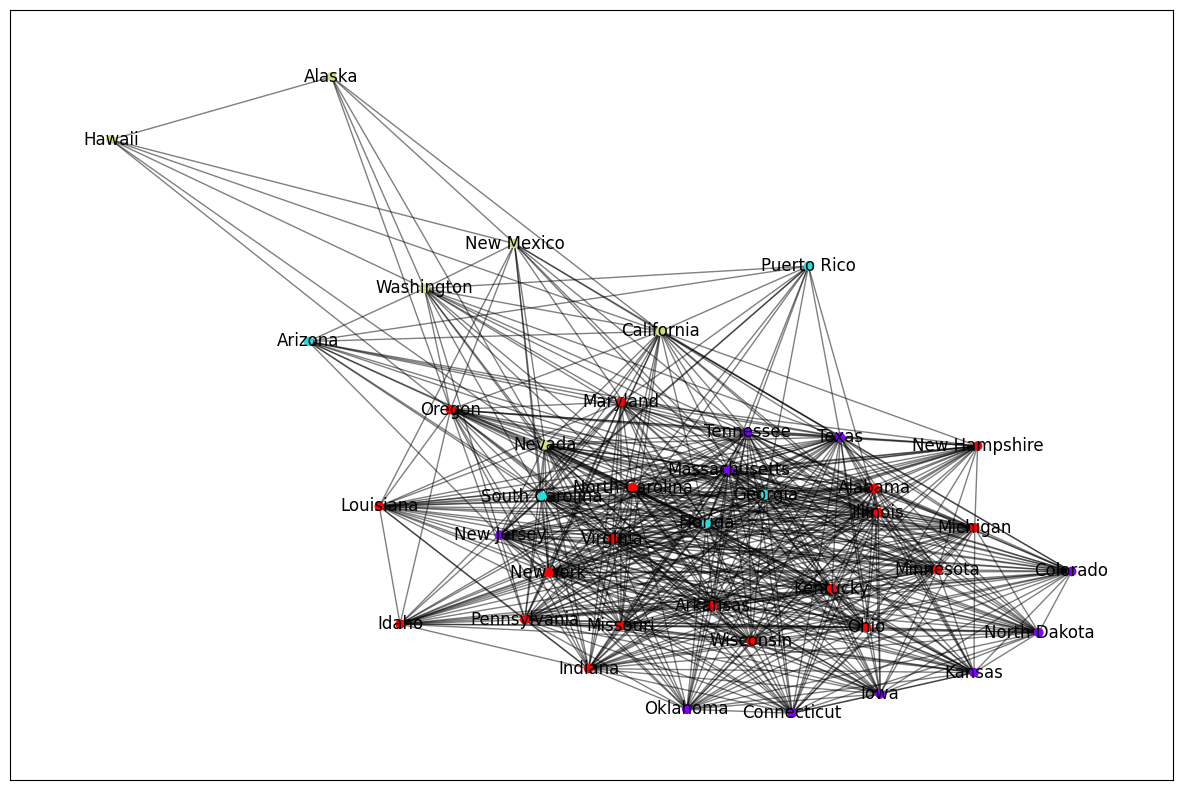

In [ ]:
#draw the graph
pos = nx.spring_layout(G)

#color the nodes according to their partition
fig = plt.figure(figsize = (15,10), dpi=100)

cmap = cm.get_cmap('rainbow', max(partition.values())+1)
nx.draw_networkx_nodes(G, pos, partition.keys(), node_size=35,cmap=cmap, node_color=list(partition.values()))
nx.draw_networkx_edges(G, pos, alpha=0.5)
nx.draw_networkx_labels(G, pos)

plt.show()

In [ ]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
# Convert the graph to a NumPy array
adjacency_matrix = nx.to_numpy_array(G)

# Get the labels for each node
labels = list(partition.values())

# Compute the silhouette score
silhouette = silhouette_score(adjacency_matrix, labels)

print(f"Silhouette Score: {silhouette}")

Silhouette Score: 0.0958072286253369


Cụm 0 #8000ff


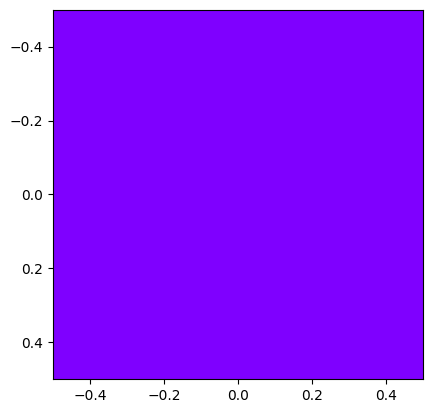

--------------------------------------
Cụm 1 #2adddd


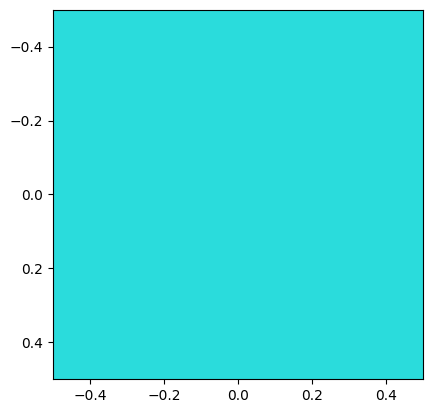

--------------------------------------
Cụm 2 #d4dd80


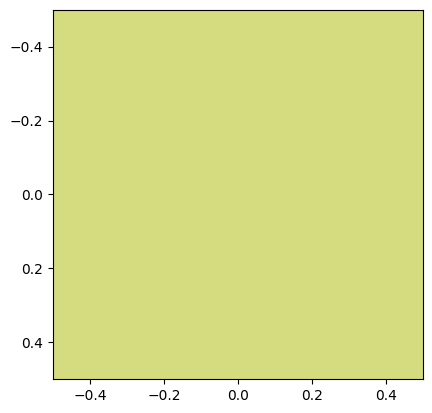

--------------------------------------
Cụm 3 #ff0000


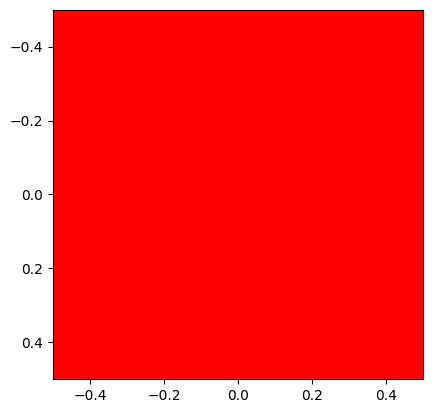

--------------------------------------


In [ ]:
for i in set(partition.values()):
    rgba = cmap(i)
    print('Cụm' ,i, matplotlib.colors.rgb2hex(rgba))
    plt.imshow([[cmap(i)]])
    plt.show()
    print('--------------------------------------')

**Kmeans**

In [ ]:
from matplotlib import colors
from sklearn.preprocessing import StandardScaler, normalize, OrdinalEncoder
from sklearn.decomposition import PCA
from sklearn.mixture import GaussianMixture 
from sklearn.metrics import silhouette_score
from sklearn.model_selection import train_test_split
from sklearn import metrics

In [ ]:
df = dt.copy()
df

,Airline,Destination
0,Southwest Airlines Co,New York
1,Southwest Airlines Co,Tennessee
141,Southwest Airlines Co,Georgia
146,Southwest Airlines Co,Texas
148,Southwest Airlines Co,Illinois
...,...,...
18315,Sun Country Airlines dba MN Airlines,Texas
18417,Sun Country Airlines dba MN Airlines,New York
18615,Sun Country Airlines dba MN Airlines,Nevada
18775,Sun Country Airlines dba MN Airlines,California


In [ ]:
from sklearn import preprocessing
label_encoder = preprocessing.LabelEncoder()
label_encoder.fit(dt.Airline)
df['AirlineID']= label_encoder.transform(df['Airline'])

In [ ]:
label_encoder.fit(dt.Destination)
df['DestinationID']= label_encoder.transform(df['Destination'])

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

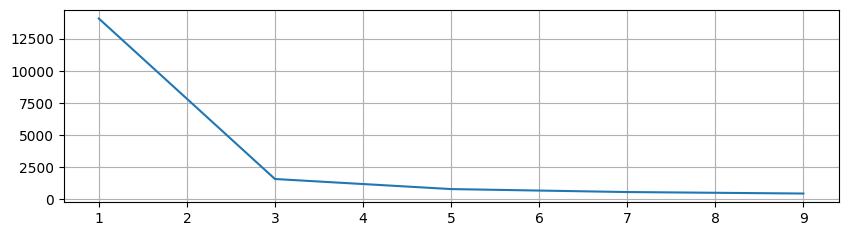

In [ ]:
# Dùng phương pháp elbow để tìm ra số cluster cho Kmeans
from sklearn.cluster import KMeans
from matplotlib import pyplot as plt

X = df[['AirlineID','DestinationID']] 
distorsions = []
for k in range(1,10,2):
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(X)
    distorsions.append(kmeans.inertia_)

fig = plt.figure(figsize=(10, 2.5))
plt.plot(range(1,10,2), distorsions)
plt.grid(True)

In [ ]:
# Dùng Kmeans predict các cụm
import matplotlib.pyplot as plt 
from sklearn.cluster import KMeans
km = KMeans(n_clusters = 3)
km 
y_predicted = km.fit_predict(df[['AirlineID','DestinationID']])
y_predicted

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


array([2, 1, 0, 1, 0, 0, 2, 0, 2, 0, 0, 1, 0, 1, 1, 2, 1, 2, 1, 2, 2, 1,
       2, 2, 0, 2, 1, 1, 2, 0, 0, 2, 1, 0, 2, 2, 2, 2, 2, 0, 1, 2, 0, 1,
       0, 0, 2, 0, 1, 1, 1, 0, 0, 0, 1, 2, 2, 2, 2, 0, 1, 2, 0, 2, 2, 0,
       2, 1, 1, 0, 0, 1, 1, 1, 0, 2, 0, 2, 1, 2, 2, 2, 0, 2, 0, 1, 2, 1,
       1, 1, 2, 0, 0, 1, 2, 0, 2, 2, 0, 0, 1, 2, 2, 0, 1], dtype=int32)

In [ ]:
df['cluster'] = y_predicted 
df 

,Airline,Destination,AirlineID,DestinationID,cluster
0,Southwest Airlines Co,New York,4,26,2
1,Southwest Airlines Co,Tennessee,4,35,1
141,Southwest Airlines Co,Georgia,4,8,0
146,Southwest Airlines Co,Texas,4,36,1
148,Southwest Airlines Co,Illinois,4,11,0
...,...,...,...,...,...
18315,Sun Country Airlines dba MN Airlines,Texas,5,36,1
18417,Sun Country Airlines dba MN Airlines,New York,5,26,2
18615,Sun Country Airlines dba MN Airlines,Nevada,5,22,2
18775,Sun Country Airlines dba MN Airlines,California,5,4,0


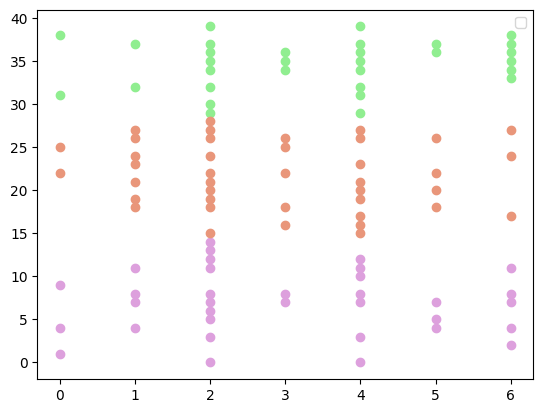

In [ ]:
df0 = df[df.cluster==0]
df1 = df[df.cluster==1]
df2 = df[df.cluster==2]
plt.scatter(df0.AirlineID,df0['DestinationID'], color='plum')
plt.scatter(df1.AirlineID,df1['DestinationID'], color='lightgreen')
plt.scatter(df2.AirlineID,df2['DestinationID'], color='darksalmon')
plt.legend()

In [ ]:
note = df.drop_duplicates(subset='Airline', keep="first")
print('Số Airline: ',len(note[['Airline','AirlineID']]))
print(note[['Airline','AirlineID']].to_string())

Số Airline:  7
                                    Airline  AirlineID
0                     Southwest Airlines Co          4
3000                    Delta Air Lines Inc          2
6000                  American Airlines Inc          1
9000                   United Air Lines Inc          6
12000                       JetBlue Airways          3
15000                   Alaska Airlines Inc          0
18000  Sun Country Airlines dba MN Airlines          5


In [ ]:
note = df.drop_duplicates(subset='Destination', keep="first")
print('Số Destination: ',len(note[['Destination','DestinationID']]))
print(note[['Destination','DestinationID']].to_string())


Số Destination:  40
          Destination  DestinationID
0            New York             26
1           Tennessee             35
141           Georgia              8
146             Texas             36
148          Illinois             11
162          Arkansas              3
163          Missouri             21
390             Idaho             10
392          Maryland             17
416           Indiana             12
426           Florida              7
444            Oregon             31
568           Alabama              0
1329             Ohio             29
1339         Virginia             37
1448         Michigan             19
1491        Wisconsin             39
1499        Louisiana             16
1509     Pennsylvania             32
1515   North Carolina             27
1526         Kentucky             15
1915   South Carolina             34
2107    New Hampshire             23
2404        Minnesota             20
3873         Oklahoma             30
3956       New Jer